# A deterministic model for electron track head location and direction reconstruction with 3-dimensional data

This is one of the companion notebooks for the paper [Low-Energy Electron-Track Imaging for a Liquid Argon Time-Projection-Chamber Telescope Concept using Probabilistic Deep Learning](https://arxiv.org/abs/2207.07805) by M. Buuck, A. Mishra, E. Charles, N. Di Lalla, O. Hitchcock, M.E. Monzani, N. Omodei, and T. Shutt

This notebook will reproduce the plots related to the deterministic deep learning analysis of electron track position and direction finding presented in the paper. You can change the drift length from 5cm to 1cm or 10cm and see different results (although not for the last section).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pickle as pl
import seaborn as sns
import pandas as pd
import datetime
import scipy.stats
import matplotlib as mpl

In [2]:
golden_ratio = (1 + np.sqrt(5))/2

In [3]:
RERUN_MODEL = False
SAVE_FIGURES = False

In [4]:
pitch = 0.2 #mm
drift = 5 #cm drift .05 is 5 cm
noise = 1

In [5]:
filename = 'deterministic_inputs_{0}cm_drift.pkl'.format(drift)
with open(filename, 'rb') as f:
    data = pl.load(f)

In [6]:
x_train = np.expand_dims(data['x_train'], -1)
x_test = np.expand_dims(data['x_test'], -1)
y_train = data['y_train']
y_test = data['y_test']
z_train = data['z_train']
z_test = data['z_test']
input_shape = x_train.shape

o_std = data['o_std']
o_mean = data['o_mean']
origins = (y_test*o_std+o_mean)
energies_test = [str(e)+' keV' for e in np.array(data['energies_test'], dtype=np.int64)]
energies_train = [str(e)+' keV' for e in np.array(data['energies_train'], dtype=np.int64)]
initial_directions = z_test*o_std*2
samples_scale = data['samples_scale']

Now we build the model, which is a sequential keras model. As you can see, it has a 3D convolutional layer with 32 filters and a stride of 3, followed (conditionally) by a max pooling layer with a stride of 2 in each dimension, followed by another stride 3 convolutional layer with 64 filters and (conditional) stride 2 max pool layer, followed finally by a 64 filter stride 3 convolutional layer and two fully-connected layers to reduce to the number of predictions (3 for `x`, `y`, and `z` of the track origin).

The max pooling layers are or are not included depending on the size of the input. For a given pixel pitch each electron track readout has the same number of pixels, but different pixel size choices lead to different numbers of pixels, since the electron track sizes do not change. If pixel pitch chosen at the top for the analysis is changed, then the network topology will also change slightly.

In [7]:
if RERUN_MODEL:
    dim = x_train[0].shape[0]
    model = models.Sequential()
    model.add(layers.Conv3D(32, 3, activation='relu', input_shape=input_shape[1:]))
    model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=18:
        model.add(layers.MaxPooling3D((2, 2, 2)))
        model.add(layers.BatchNormalization())
        dim /= 2

    model.add(layers.Conv3D(64, 3, activation='relu'))
    model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=6:
        model.add(layers.MaxPooling3D((2, 2, 2)))
        model.add(layers.BatchNormalization())
        dim /= 2

    model.add(layers.Conv3D(128, 3, activation='relu'))
    model.add(layers.SpatialDropout3D(0.25))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling3D())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128))
    model.add(layers.Dense(3))

    model.summary()

Finally we compile the model and fit it to the training data. We use the MSE as the loss function, since we are doing regression and many of the available loss functions are only relevant to classification problems. We also keep track of the RMSE and [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) for plotting later.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
xtemp=np.concatenate([x_train, x_test], axis=0)
ytemp=np.concatenate([y_train, y_test], axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(xtemp, ytemp, test_size=0.075, random_state=42)

In [10]:
if RERUN_MODEL:
    epochs=200
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    tf.random.set_seed(42)
    log_dir = "logs/deterministic_model_{0}cm_drift/{1}".format(drift, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, Y_test))
    model.save('deterministic_model_drift_{0}cm'.format(drift))

Epoch 1/200
134/134 [==============================] - 40s 27ms/step - loss: 0.7134 - val_loss: 1.0526
Epoch 2/200
134/134 [==============================] - 3s 23ms/step - loss: 0.4099 - val_loss: 1.0331
Epoch 3/200
134/134 [==============================] - 3s 22ms/step - loss: 0.3628 - val_loss: 0.9872
Epoch 4/200
134/134 [==============================] - 3s 23ms/step - loss: 0.3384 - val_loss: 0.7245
Epoch 5/200
134/134 [==============================] - 3s 23ms/step - loss: 0.3212 - val_loss: 0.4425
Epoch 6/200
134/134 [==============================] - 3s 23ms/step - loss: 0.3049 - val_loss: 0.2956
Epoch 7/200
134/134 [==============================] - 3s 22ms/step - loss: 0.2945 - val_loss: 0.2179
Epoch 8/200
134/134 [==============================] - 3s 23ms/step - loss: 0.2860 - val_loss: 0.2109
Epoch 9/200
134/134 [==============================] - 3s 23ms/step - loss: 0.2814 - val_loss: 0.2115
Epoch 10/200
134/134 [==============================] - 3s 23ms/step - loss: 0.27

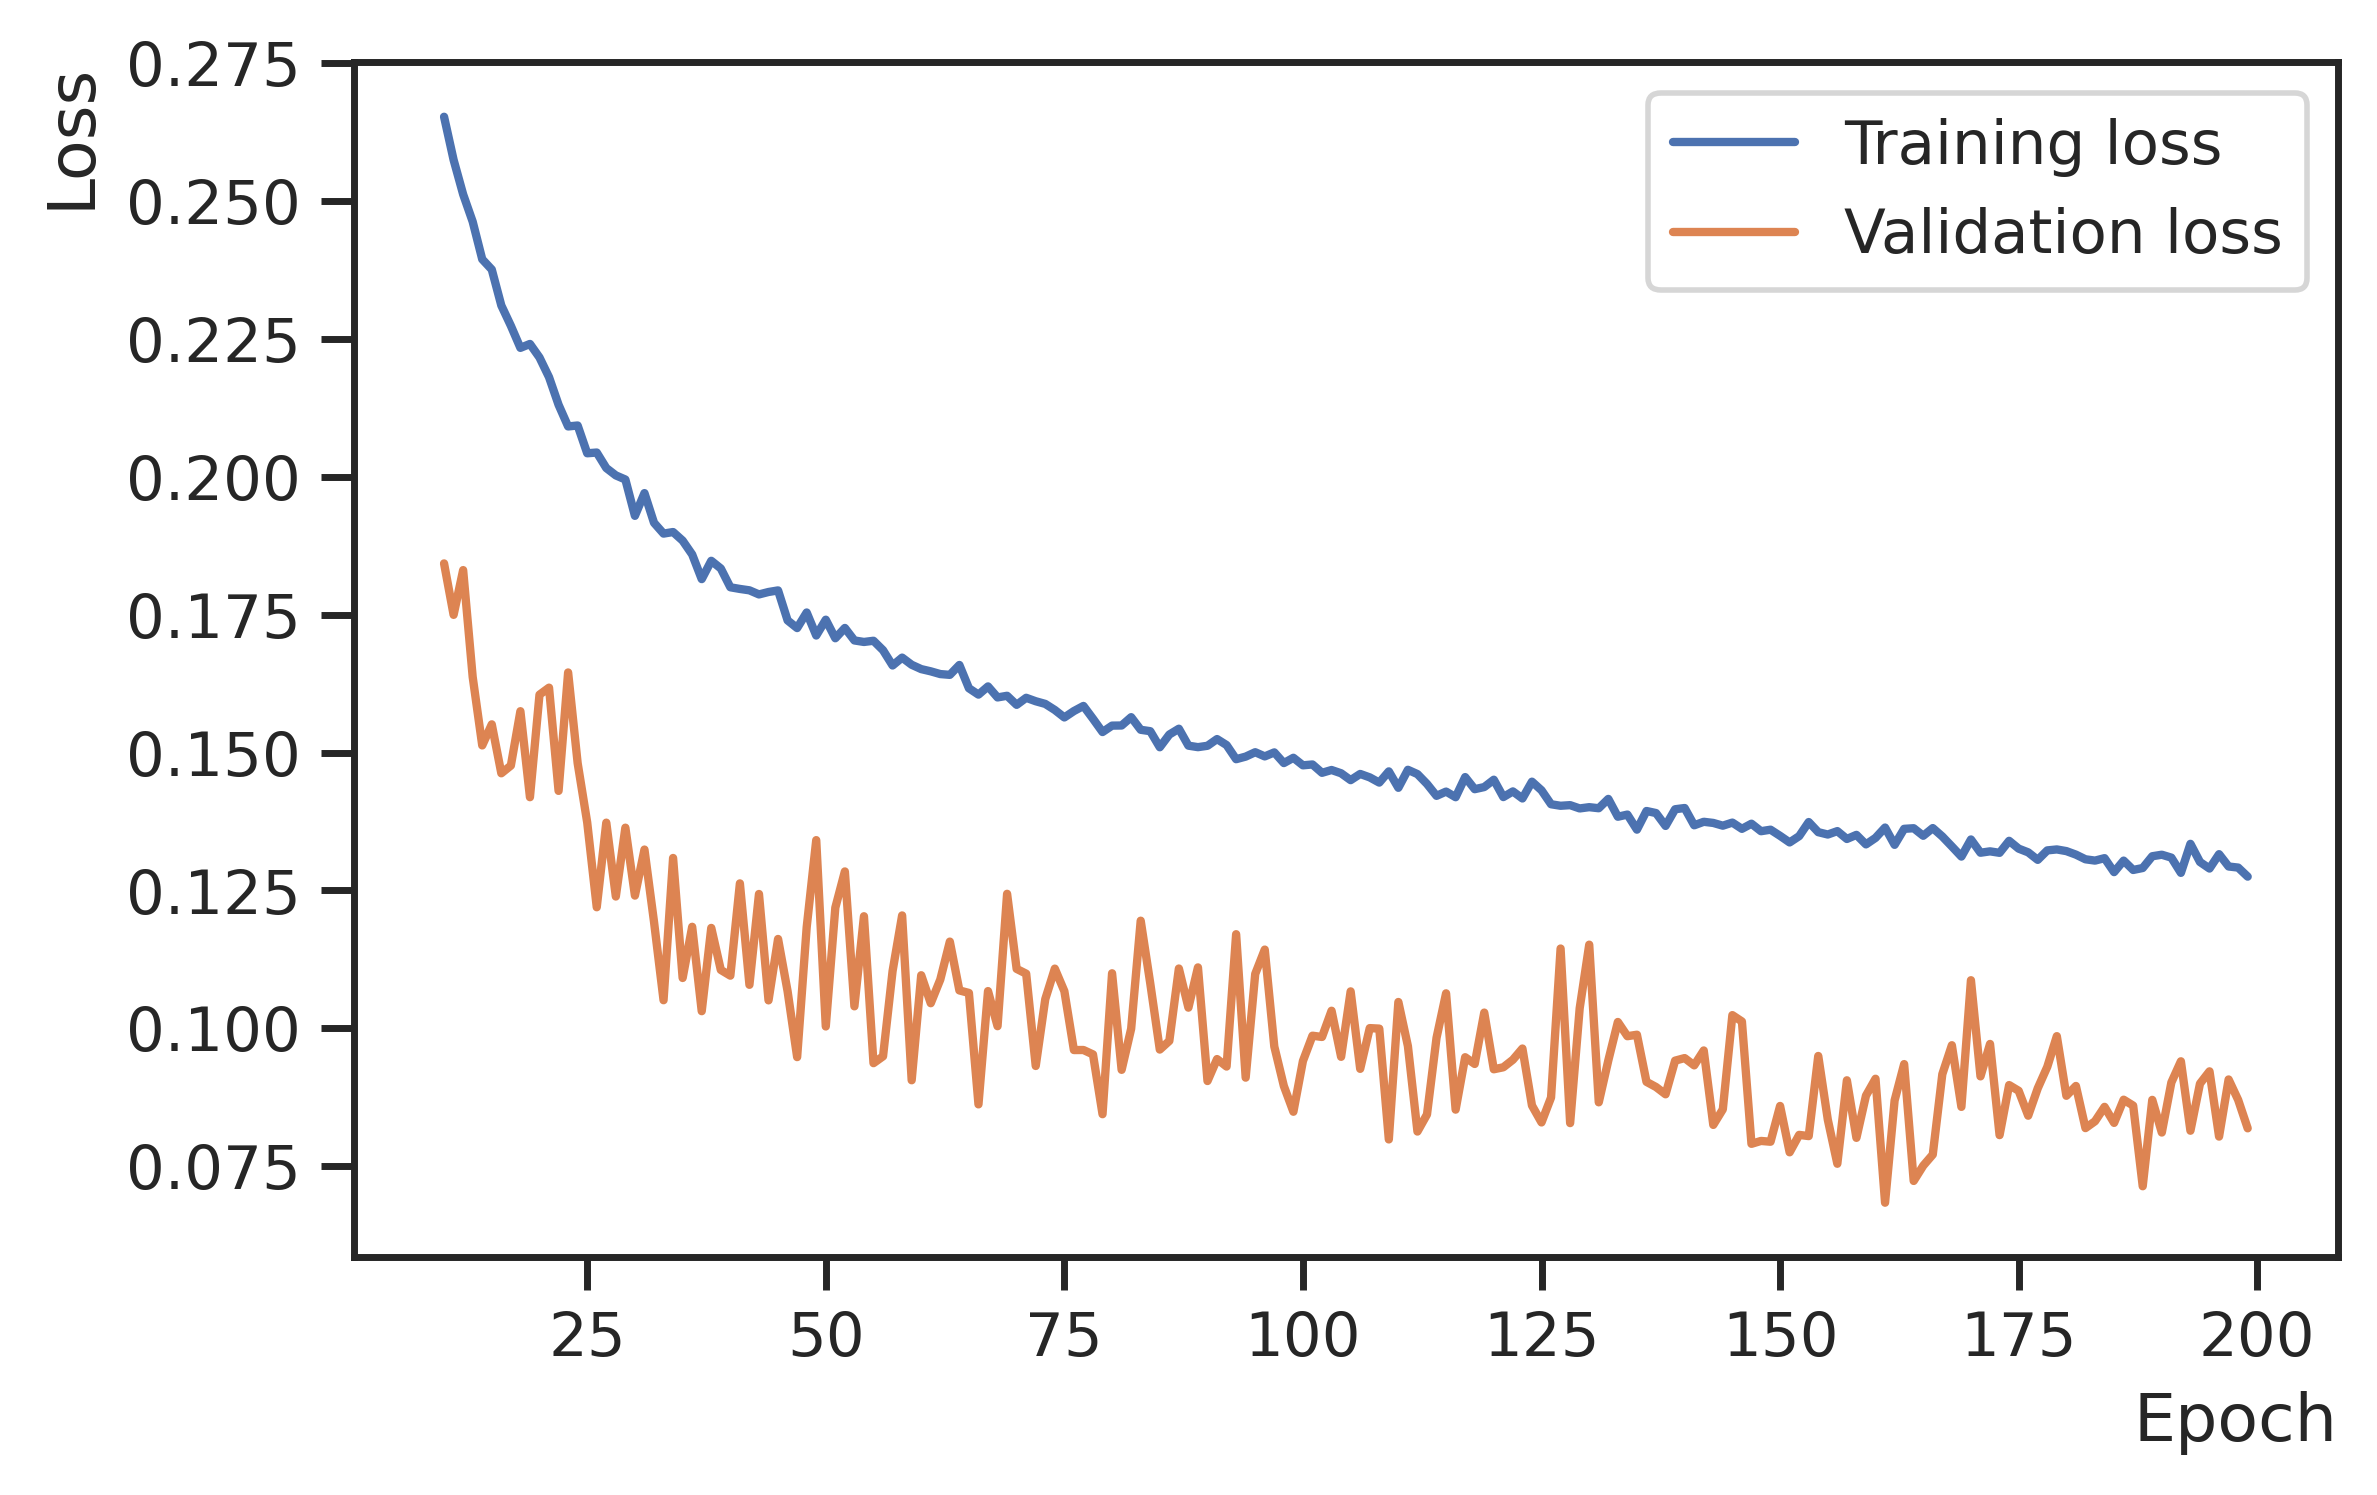

In [13]:
if RERUN_MODEL:
    sns.set_theme('notebook', 'ticks')
    plt.figure(dpi=400, figsize=(6.4, 6.4/golden_ratio))
    plt.plot(np.linspace(10,len(history.history["loss"])-1, len(history.history["loss"][10:])), history.history["loss"][10:], label='Training loss')
    plt.plot(np.linspace(10,len(history.history["loss"])-1, len(history.history["loss"][10:])), history.history["val_loss"][10:], label='Validation loss')
    plt.legend()
    plt.gca().set_xlabel("Epoch", loc='right')
    plt.gca().set_ylabel("Loss", loc='top')

In [9]:
if not RERUN_MODEL:
    model = keras.models.load_model('deterministic_model_drift_{0}cm'.format(drift))

### Assess model output

We will compare the predicted electron origins to the actual origins, and plot the RMSE (a.k.a. the Euclidean distance), split out by initial electron energy.

In [10]:
unscaled_predictions = model.predict(x_test)
predictions = (unscaled_predictions*o_std)+o_mean

In [11]:
rmses = np.sqrt(np.sum((origins-predictions)**2, axis=1))*1000
mses = rmses**2
errors = origins-predictions
error = 'Error (mm)'
squared_error = 'Sq Error (mm${}^2$)'
abs_error = 'Abs Error (mm)'
z_score_name = 'Z score'
pred_error = 'Predicted Abs Error (mm)'
pred_sq_error = 'Predicted Sq Error (mm${}^2$)'
energy = 'Initial Electron Energy'
df0 = pd.DataFrame(data={'rmses': rmses, 'mses':mses, 'X '+error:errors[:,0]*1000, 'Y '+error:errors[:,1]*1000, 'Z '+error:errors[:,2]*1000, energy: energies_test})
df1 = pd.DataFrame(data={error:errors.flatten()*1000, squared_error:((errors - np.mean(errors, axis=0)).flatten()*1000)**2, abs_error:np.sqrt(((errors- np.mean(errors, axis=0)).flatten()*1000)**2), energy:np.repeat(energies_test, 3)})

In [12]:
from scipy.stats import norm

In [13]:
pal1 = sns.color_palette('Paired')[0::2][:5]
pal2 = sns.color_palette('Paired')[1::2][:5]
pal3 = sns.color_palette('Dark2')

50 keV
    mu: -3.868e-03 +- 2.860e-04
    sigma (68% CI) 1.927e-02 (1.907e-02, 1.948e-02)

300 keV
    mu: 6.605e-03 +- 2.060e-03
    sigma (68% CI) 1.383e-01 (1.369e-01, 1.398e-01)

500 keV
    mu: 1.273e-03 +- 2.381e-03
    sigma (68% CI) 1.575e-01 (1.558e-01, 1.592e-01)

750 keV
    mu: 5.727e-03 +- 3.300e-03
    sigma (68% CI) 2.146e-01 (2.123e-01, 2.170e-01)

1000 keV
    mu: 2.296e-03 +- 4.812e-03
    sigma (68% CI) 3.181e-01 (3.147e-01, 3.215e-01)



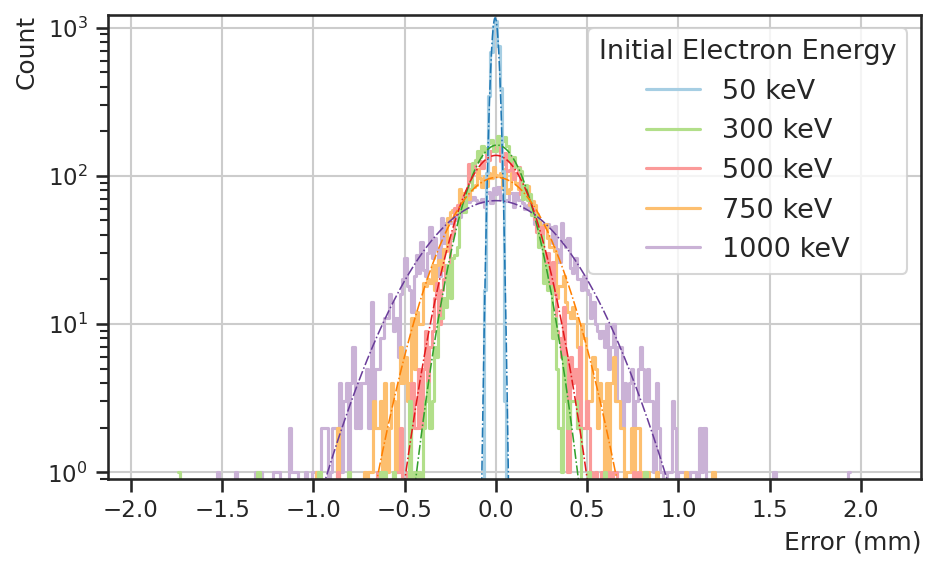

In [14]:
context = 'notebook'
style = 'ticks'
fmt = 'png'
sns.set_theme(context, style)
fig_dpi = 150
plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))

hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']
ax = sns.histplot(data=df1, x=error, hue=energy, element='step', fill=False, palette=pal1, hue_order=hue_order)
plt.legend(ax.get_legend().legendHandles, hue_order, title=energy, title_fontsize=13, fontsize=13)

bin_width = np.diff(ax.get_lines()[0].get_xdata())[0]
x = np.linspace(*ax.get_xlim(), 2001)
sigma = 1
i=0
fit_params_all_energies = {}
for en in hue_order:
    fit_params = norm.fit(df1[df1[energy]==en][error])
    fit_params_all_energies[en] = fit_params
    normalization = len(df1[df1[energy]==en])*(bin_width)
    plt.plot(x, normalization*norm.pdf(x, *fit_params), '-.', linewidth=0.75, c=pal2[i])
    alpha = 1-(scipy.stats.norm.cdf(sigma) - scipy.stats.norm.cdf(-sigma))
    n = df1[df1[energy]==en].shape[0]
    print(en)
    print("    mu: {0:.3e} +- {1:.3e}".format(fit_params[0], scipy.stats.t.ppf(1-alpha/2, n-1)/np.sqrt(n)*fit_params[1]))
    print("    sigma ({0:.0f}% CI) {1:.3e} ({2:.3e}, {3:.3e})\n".format(100*(1-alpha), fit_params[1], np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(1-alpha/2, n-1)), np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(alpha/2, n-1))))
    i += 1

ax.set_ylim([9e-1, ax.get_ylim()[1]])
ax.set_yscale('log')
ax.set_xlabel(ax.get_xlabel(), loc='right')
ax.set_ylabel(ax.get_ylabel(), loc='top')
plt.grid('major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("fitted_error_distributions_{0}_{1}.{2}".format(context, style, fmt), format=fmt)
plt.show()

In [15]:
hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']
energies_test = np.array(energies_test)
squared_error = 'Sq Error (mm${}^2$)'
abs_error = 'Abs Error (mm)'
df_abs = pd.DataFrame(
    data={
        energy:np.concatenate([np.repeat(en, energies_test[energies_test==en].shape[0]) for en in hue_order]),
        abs_error:np.concatenate([np.sqrt(np.sum((errors[energies_test==en] - np.mean(errors[energies_test==en], axis=0))**2, axis=1)) for en in hue_order])*1000,
        squared_error:np.concatenate([np.sum(((errors[energies_test==en] - np.mean(errors[energies_test==en], axis=0))*1000)**2, axis=1) for en in hue_order])
    }
)

50 keV mean absolute error: 0.02400502414109771
300 keV mean absolute error: 0.21069891561941403
500 keV mean absolute error: 0.24443937965585155
750 keV mean absolute error: 0.33300674263371716
1000 keV mean absolute error: 0.4892942073784357


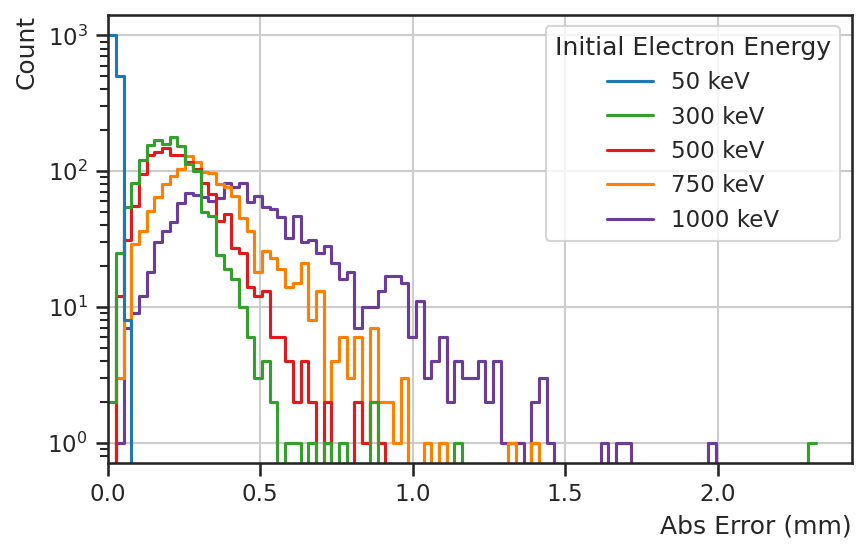

In [16]:
context='notebook'
style='ticks'
fmt='png'
fig_dpi = 150

sns.set_theme(context, style)

plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))
hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']

ax = sns.histplot(data=df_abs, x=abs_error, hue=energy, element='step', fill=False, palette=pal2, hue_order=hue_order)
for en in hue_order:
    print(en, "mean absolute error:", df_abs[df_abs[energy]==en][abs_error].mean())

ax.set_xlabel(ax.get_xlabel(), loc='right')
ax.set_ylabel(ax.get_ylabel(), loc='top')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_yscale('log')
ax.grid(which='major')
if SAVE_FIGURES:
    plt.savefig("abs_error_distributions_{0}_{1}.{2}".format(context, style), bbox_inches='tight', format=fmt)
plt.show()

Print the squared error so that it can be plotted in the summary plot in `2022_summary_plots.ipynb`

In [17]:
for en in hue_order:
    print(en, "mean squared error:", df_abs[df_abs[energy]==en][squared_error].mean())

50 keV mean squared error: 0.0006627799448244386
300 keV mean squared error: 0.05694358622275712
500 keV mean squared error: 0.0734753168959732
750 keV mean squared error: 0.13747909758708365
1000 keV mean squared error: 0.302278296517154


In general, electrons with a lower starting energy have an origin that is easier to locate. This is probably because the lower energy electrons do not travel very far inside the detector before stopping, so the detected energy is fairly localized. This can be seen in the subsequent plots.

### Make 3D comparison plots
Make plots of track samples, predicted track origin, and true track origin

Here we define a function to make our 3D plots, since we will be producing a bunch of them

In [18]:
def plot_3D(i, x, y, z, hits, energies_test, origins=None, predictions=None, ids=None, id_predictions=None, unc_predictions=None, filename=None, fmt=None, figwidth=None, labelpad=None, fig_dpi=150):
    x_low = x[np.argmin(x*(hits[i]>0))]*1000
    x_up = x[np.argmax(x*(hits[i]>0))]*1000
    y_low = y[np.argmin(y*(hits[i]>0))]*1000
    y_up = y[np.argmax(y*(hits[i]>0))]*1000
    z_low = z[np.argmin(z*(hits[i]>0))]*1000
    z_up = z[np.argmax(z*(hits[i]>0))]*1000

    if figwidth is not None:
        fig = plt.figure(figsize=(figwidth,figwidth*3/4), dpi=fig_dpi)
    else:
        fig = plt.figure(dpi=fig_dpi)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(energies_test[i]+" Electron track", pad=labelpad)
    ax.set_xlim([x_low, x_up])
    ax.set_ylim([y_low, y_up])
    ax.set_zlim([z_low, z_up])
    ax.set_xlabel('x (mm)', labelpad=labelpad)
    ax.set_ylabel('y (mm)', labelpad=labelpad)
    ax.set_zlabel('z (mm)', labelpad=labelpad)
    
    ax.scatter(x*1000, y*1000, z*1000, s=hits[i], alpha=0.1, c=hits[i], edgecolors='b', linewidth=0)
    if origins is not None:
        ax.scatter(origins[i,0]*1000, origins[i,1]*1000, origins[i,2]*1000, s=25, c=[[1.0, 0.4980392156862745, 0.054901960784313725]], label='True origin')
    if predictions is not None:
        ax.scatter(predictions[i,0]*1000, predictions[i,1]*1000, predictions[i,2]*1000, s=25, c=[[0.17254901960784313, 0.6274509803921569, 0.17254901960784313]], label='Predicted origin')
    if ids is not None and origins is not None:
        ax.quiver(origins[i,0]*1000, origins[i,1]*1000, origins[i,2]*1000, ids[i, 0]*1000*1.5, ids[i,1]*1000*1.5, ids[i,2]*1000*1.5, color=[[1.0, 0.4980392156862745, 0.054901960784313725]], label="True initial direction")
    if id_predictions is not None and predictions is not None:
        ax.quiver(predictions[i,0]*1000, predictions[i,1]*1000, predictions[i,2]*1000, id_predictions[i, 0]*1000*1.5, id_predictions[i,1]*1000*1.5, id_predictions[i,2]*1000*1.5, color=[[0.17254901960784313, 0.6274509803921569, 0.17254901960784313]], label="Predicted initial direction")
    if unc_predictions is not None and predictions is not None:
        rx, ry, rz = unc_predictions[i,0]*1000, unc_predictions[i,1]*1000, unc_predictions[i,2]*1000

        # Set of all spherical angles:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        # Cartesian coordinates that correspond to the spherical angles:
        # (this is the equation of an ellipsoid):
        x = rx * np.outer(np.cos(u), np.sin(v)) + 1000*predictions[i,0]
        y = ry * np.outer(np.sin(u), np.sin(v)) + 1000*predictions[i,1]
        z = rz * np.outer(np.ones_like(u), np.cos(v)) + 1000*predictions[i,2]
        ax.plot_surface(x, y, z,  color=[0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.2], linewidth=0.05)
        
    ax.legend()
    if filename is not None and fmt is None:
        plt.savefig(filename+'.png', format='png')
    elif filename is not None and fmt is not None:
        plt.savefig(filename+'.'+fmt, format=fmt)
    elif filename is None and fmt is not None:
        print("Cannot save with only format specification and no filename! Please supply filename.")

Process data so it can be presented in a plot

In [19]:
pitch_m = pitch/1e3
x_centers = np.arange(-(input_shape[1]-1)/2*pitch_m, (input_shape[1]-1)/2*pitch_m+pitch_m, pitch_m)
y_centers = np.arange(-(input_shape[2]-1)/2*pitch_m, (input_shape[2]-1)/2*pitch_m+pitch_m, pitch_m)
z_centers = np.arange(-(input_shape[3]-1)/2*pitch_m, (input_shape[3]-1)/2*pitch_m+pitch_m, pitch_m)

x = np.array([x for x in x_centers for y in y_centers for z in z_centers])
y = np.array([y for x in x_centers for y in y_centers for z in z_centers])
z = np.array([z for x in x_centers for y in y_centers for z in z_centers])

hits = np.reshape(x_test, (-1, len(x_centers)*len(y_centers)*len(z_centers)))*samples_scale

In [20]:
most_err = np.argmax(rmses)
least_err = np.argmin(rmses)
median_err = np.argwhere(rmses==sorted(rmses)[int(len(rmses)/2)])[0,0]

In [21]:
least_err_1000_keV = int(np.linspace(0, len(energies_test)-1, len(energies_test))[np.array(energies_test)=='1000 keV'][np.argmin(rmses[np.array(energies_test)=='1000 keV'])])
most_err_1000_keV = int(np.linspace(0, len(energies_test)-1, len(energies_test))[np.array(energies_test)=='1000 keV'][np.argmax(rmses[np.array(energies_test)=='1000 keV'])])

We're going to look at a few examples, specifically the samples with the least, median, and most error, in that order.

The 3D plot below shows an example electron track, with the initial origin and scattering direction shown. The first cell saves a version of it to disk, and the second shows an interactive 3D plot.

In this example, a gamma ray has scattered off an electron at the location of the red dot, and the ricocheting electron has deposited its energy along a track. The initial direction of its scatter is the red arrow (arrow length is only for illustrative purposes). The blue points show the response of the detector to the energy depositions of the electron.

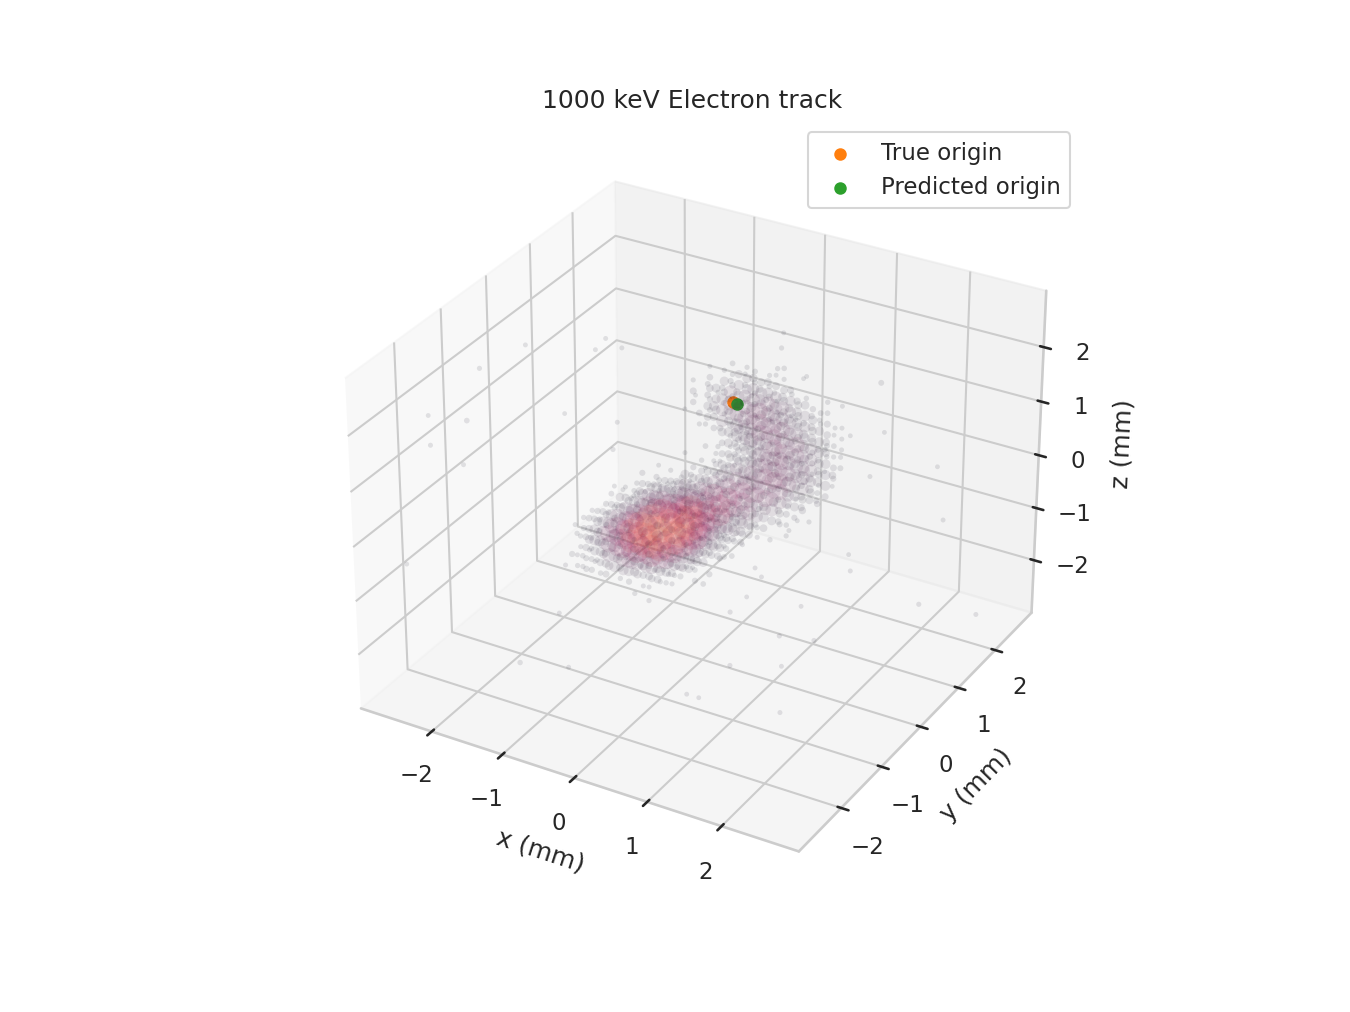

In [22]:
%matplotlib widget
sns.set_theme(context='notebook', style='whitegrid')
plt.ion()
plot_3D(least_err_1000_keV, x, y, z, hits, energies_test, origins=origins, predictions=predictions, figwidth=9)

Median error: The track shown at time of writing is a few millimeters long, and hooks around about halfway along its length. It can be seen that there is more energy deposited at the end of the track than at the beginning. This can in theory help the network determine which end of the track is the head.

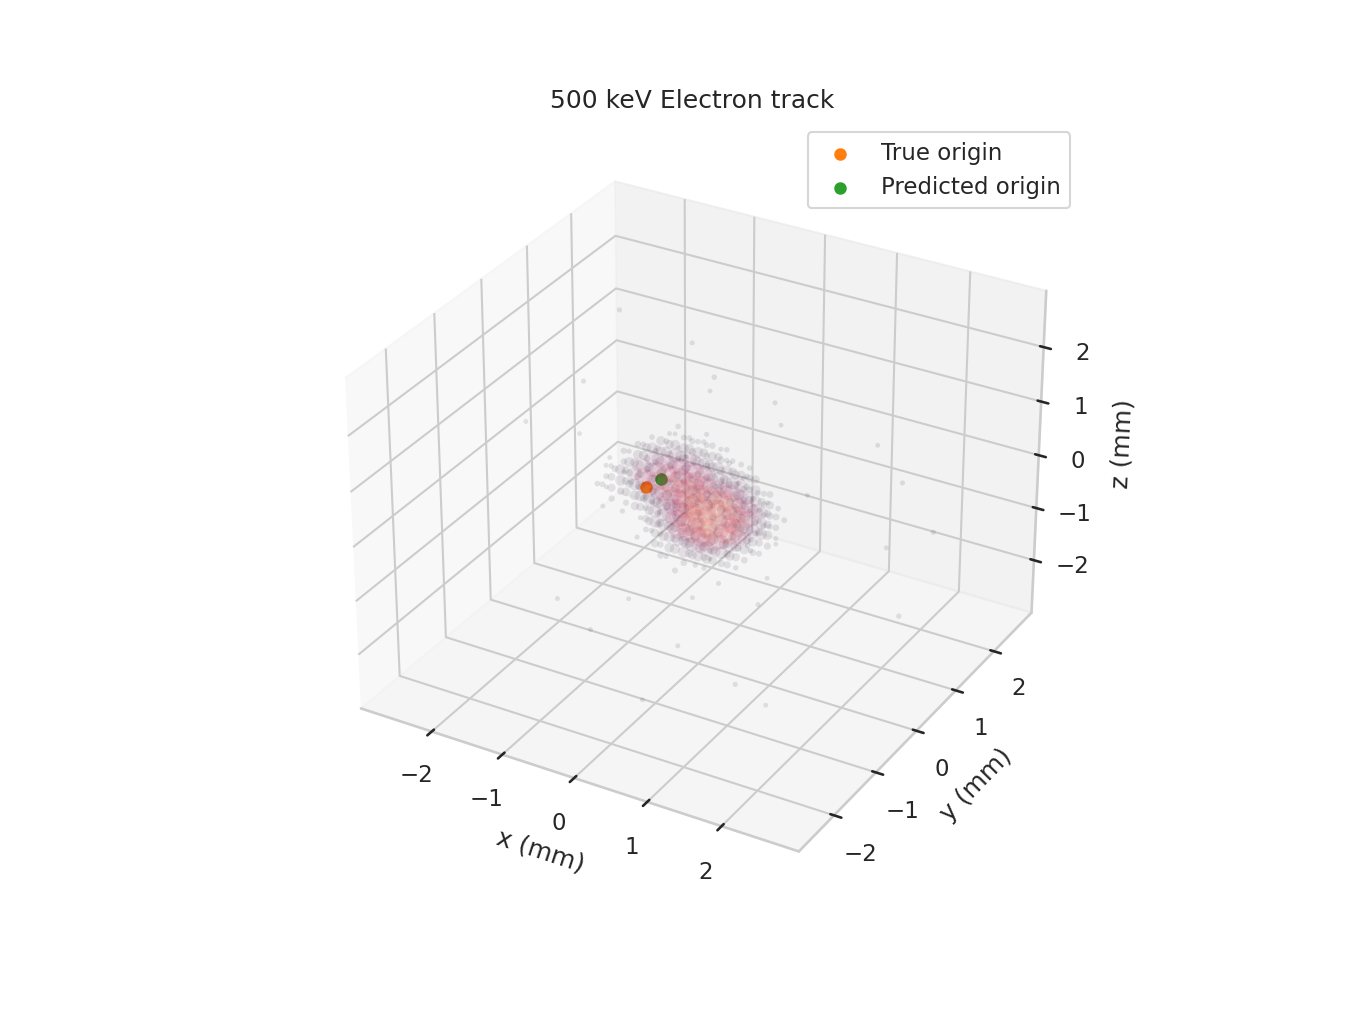

In [23]:
%matplotlib widget
sns.set_theme(context='notebook', style='whitegrid')
plt.ion()
plot_3D(median_err, x, y, z, hits, energies_test, origins=origins, predictions=predictions, figwidth=9)

Most error: These examples will not necessarily be identical from run to run of this notebook, but the example shown at the time of writing shows a 750 keV track where the predicted origin is clearly separated from the area of the energy deposition.

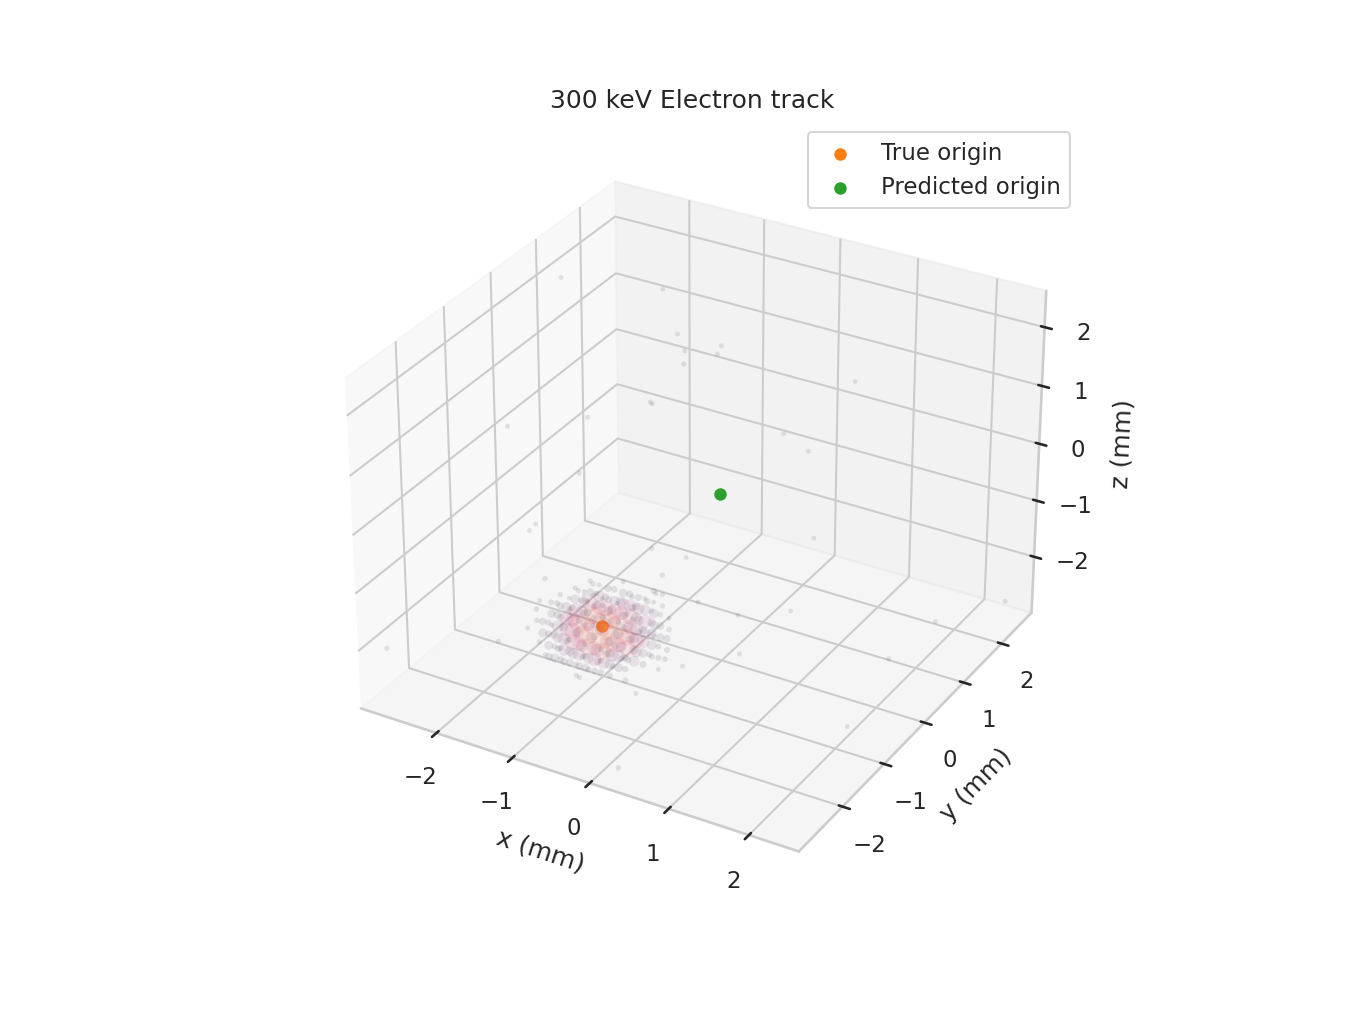

In [24]:
%matplotlib widget
sns.set_theme(context='notebook', style='whitegrid')
plt.ion()
plot_3D(most_err, x, y, z, hits, energies_test, origins=origins, predictions=predictions, figwidth=9)

### Create network to estimate initial direction of electron ###

Estimating the initial direction of scatter for each electron is also quite useful. Scattering twice within the detector constrains the initial direction of an incident gamma ray to a circle on the sky, as long as the energy of the first scatter is measured. If the initial direction of the scattered electron is measured, that is enough information to kinematically restrict the origin of the gamma ray to a single point on the sky. Therefore measuring the initial scattering direction, as well as estimating the uncertainty of the measurement, significantly increases the pointing ability of the detector.

We present another CNN to determine the initial scattering direction. The design is identical to that of the network for estiating the position uncertainty, except that it returns 3 values instead of 1, which are trained against the initial direction vectors.

In [32]:
if RERUN_MODEL:
    dim = x_train[0].shape[0]
    id_model = models.Sequential()
    id_model.add(layers.Conv3D(32, 3, activation='relu', input_shape=input_shape[1:]))
    id_model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=18:
        id_model.add(layers.MaxPooling3D((2, 2, 2)))
        id_model.add(layers.BatchNormalization())
        dim /= 2

    id_model.add(layers.Conv3D(64, 3, activation='relu'))
    id_model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=6:
        id_model.add(layers.MaxPooling3D((2, 2, 2)))
        id_model.add(layers.BatchNormalization())
        dim /= 2

    id_model.add(layers.Conv3D(128, 3, activation='relu'))
    id_model.add(layers.SpatialDropout3D(0.25))
    id_model.add(layers.BatchNormalization())
    id_model.add(layers.GlobalAveragePooling3D())
    id_model.add(layers.Dropout(0.25))
    id_model.add(layers.Dense(128))
    id_model.add(layers.Dense(3))

    id_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 28, 28, 28, 32)    896       
_________________________________________________________________
spatial_dropout3d_6 (Spatial (None, 28, 28, 28, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 14, 14, 14, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 14, 32)    128       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 12, 12, 12, 64)    55360     
_________________________________________________________________
spatial_dropout3d_7 (Spatial (None, 12, 12, 12, 64)    0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 6, 6, 6, 64)      

In [33]:
if RERUN_MODEL:
    epochs=20
    id_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    tf.random.set_seed(42)
    log_dir = "logs/deterministic_model_initial_direction_{0}cm_drift/{1}".format(drift, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    id_history = id_model.fit({'pixels': x_train}, z_train, epochs=20, validation_data=({'pixels':x_test}, z_test))
    id_model.save("deterministic_model_initial_direction_drift_{0}cm".format(drift))

Epoch 1/20
536/536 [==============================] - 6s 11ms/step - loss: 0.3575 - val_loss: 0.3323
Epoch 2/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3256 - val_loss: 0.3116
Epoch 3/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3186 - val_loss: 0.3090
Epoch 4/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3145 - val_loss: 0.3084
Epoch 5/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3109 - val_loss: 0.3058
Epoch 6/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3099 - val_loss: 0.3012
Epoch 7/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3080 - val_loss: 0.2977
Epoch 8/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3058 - val_loss: 0.2984
Epoch 9/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3049 - val_loss: 0.2967
Epoch 10/20
536/536 [==============================] - 5s 10ms/step - loss: 0.3045 - val_lo

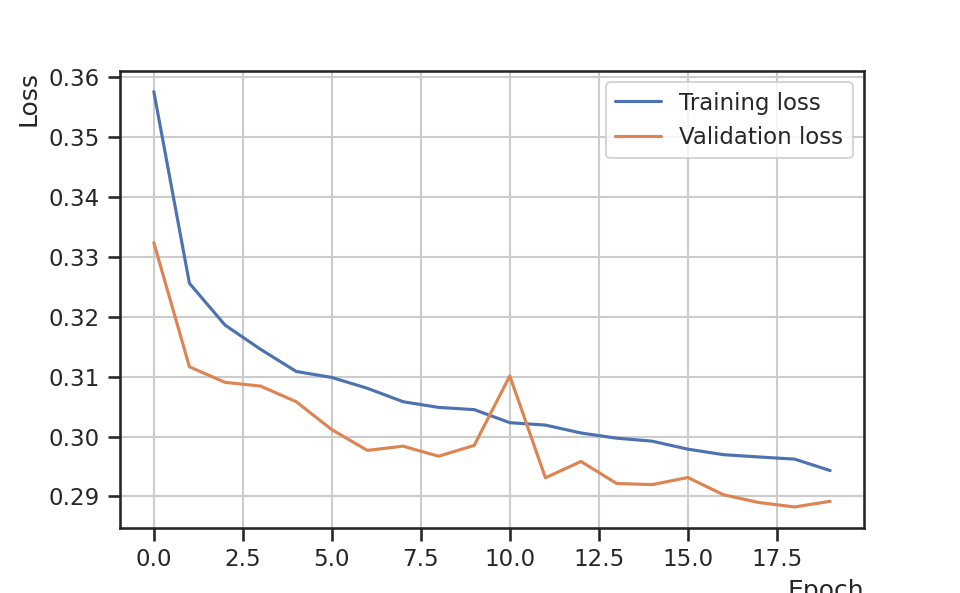

In [35]:
if RERUN_MODEL:
    context='notebook'
    style='ticks'
    fig_dpi=150
    sns.set_theme(context, style)
    plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))
    plt.plot(np.linspace(0,len(id_history.history["loss"])-1, len(id_history.history["loss"])), id_history.history["loss"], label='Training loss')
    plt.plot(np.linspace(0,len(id_history.history["loss"])-1, len(id_history.history["loss"])), id_history.history["val_loss"], label='Validation loss')
    plt.legend()
    plt.gca().set_xlabel("Epoch", loc='right')
    plt.gca().set_ylabel("Loss", loc='top')
    plt.gca().grid('major')

In [25]:
if not RERUN_MODEL:
    id_model = keras.models.load_model('deterministic_model_initial_direction_drift_{0}cm'.format(drift))

In [26]:
id_predictions = id_model.predict({'pixels':x_test})

In [27]:
df = pd.DataFrame(
    data={
        'id_dot_prod':np.array([np.dot(initial_directions[i]/np.linalg.norm(initial_directions[i]), id_predictions[i]/np.linalg.norm(id_predictions[i])) for i in range(len(initial_directions))]),
        energy:energies_test
    }
)

We show the dot products of the initial scatter directions with the predicted scatter directions in the test data. A value of 1 indicates perfect identification of the starting direction, while a value of -1 indicates a predicted direction exactly opposite to the true starting direction. Random guessing would produce a uniform distribution.

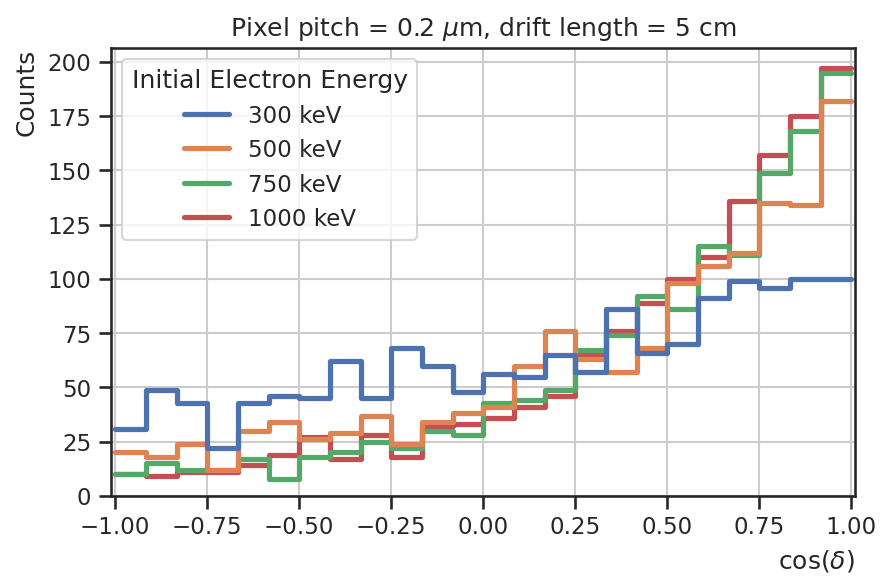

In [28]:
%matplotlib inline
plt.ion()
context='notebook'
style='ticks'
fmt='png'
fig_dpi=150
sns.set_theme(context=context, style=style)

fig = plt.figure(figsize=(6.4,6.4/golden_ratio), dpi=fig_dpi)
ax = plt.gca()
ax = sns.histplot(data=df[df[energy]!='50 keV'], x='id_dot_prod', hue=energy, ax=ax, fill=False, element='step', linewidth=2.5, hue_order=hue_order[1:])

xlim = ax.get_xlim()
plt.gca().set_ylabel('Counts', loc='top')
plt.gca().set_xlabel('cos($\delta$)', loc='right')
plt.gca().set_title('Pixel pitch = '+str(pitch)+' $\mu$m, drift length = '+str(drift)+' cm')
plt.grid('major')
plt.xlim(-1.01,1.01)
if SAVE_FIGURES:
    plt.savefig('case5_direction_V14.{0}'.format(fmt), bbox_inches='tight')
plt.show()

In [29]:
best_direction = np.argmax(df['id_dot_prod'])
worst_direction = np.argmin(df['id_dot_prod'])

Finally, we will again show some examples, namely the best estimate and worst estimate, in that order.

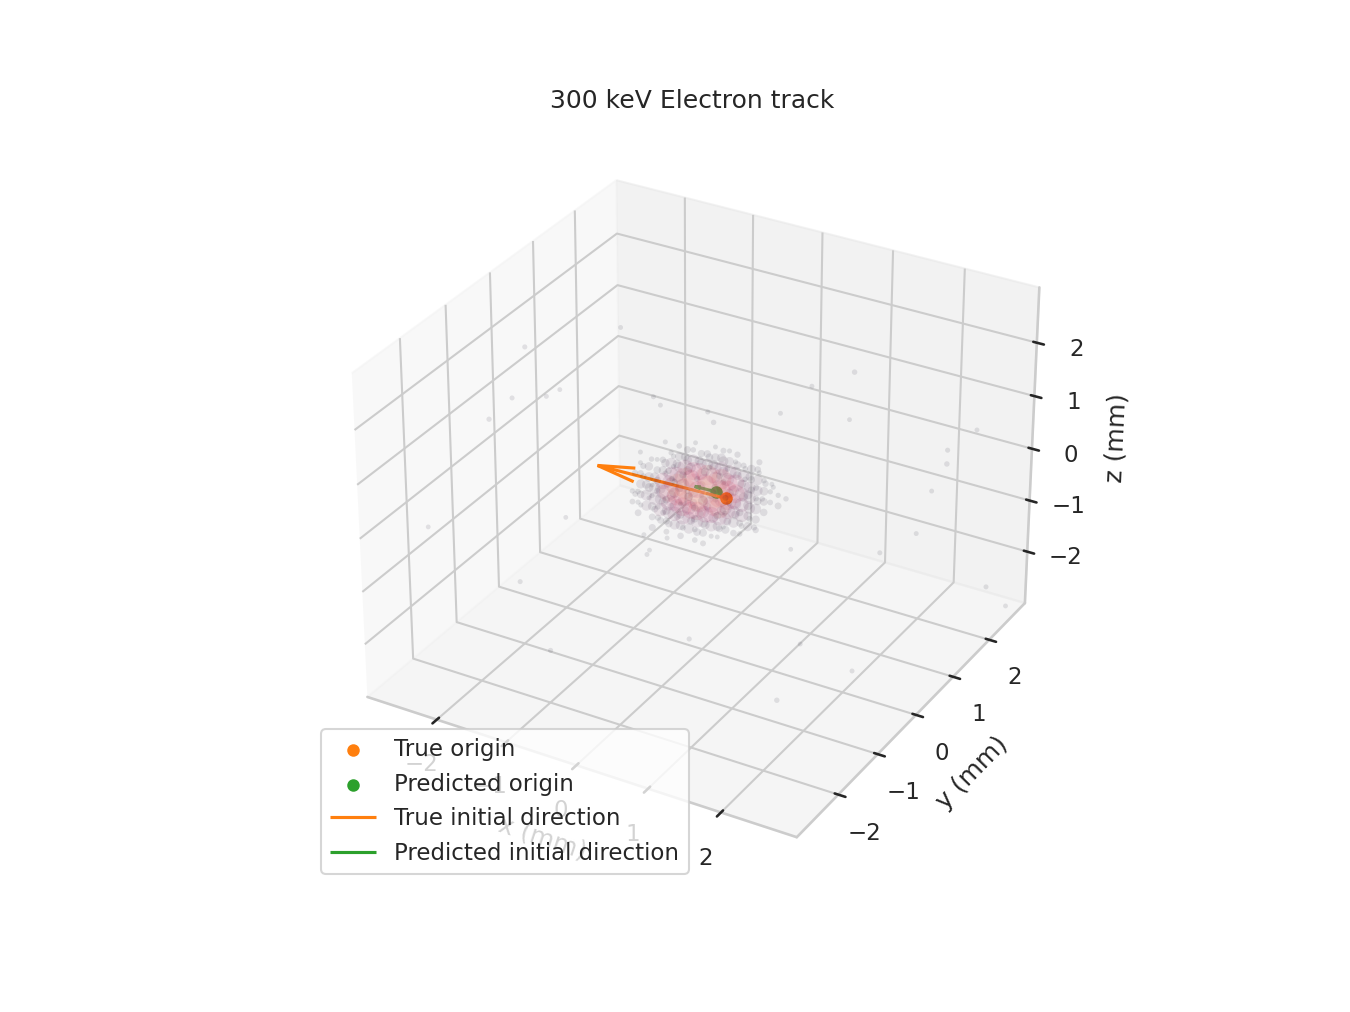

In [32]:
%matplotlib widget
sns.set_theme(context='notebook', style='whitegrid')
plt.ion()
plot_3D(best_direction, x, y, z, hits, energies_test, origins=origins, predictions=predictions, ids=initial_directions, id_predictions=id_predictions/1000, figwidth=9)

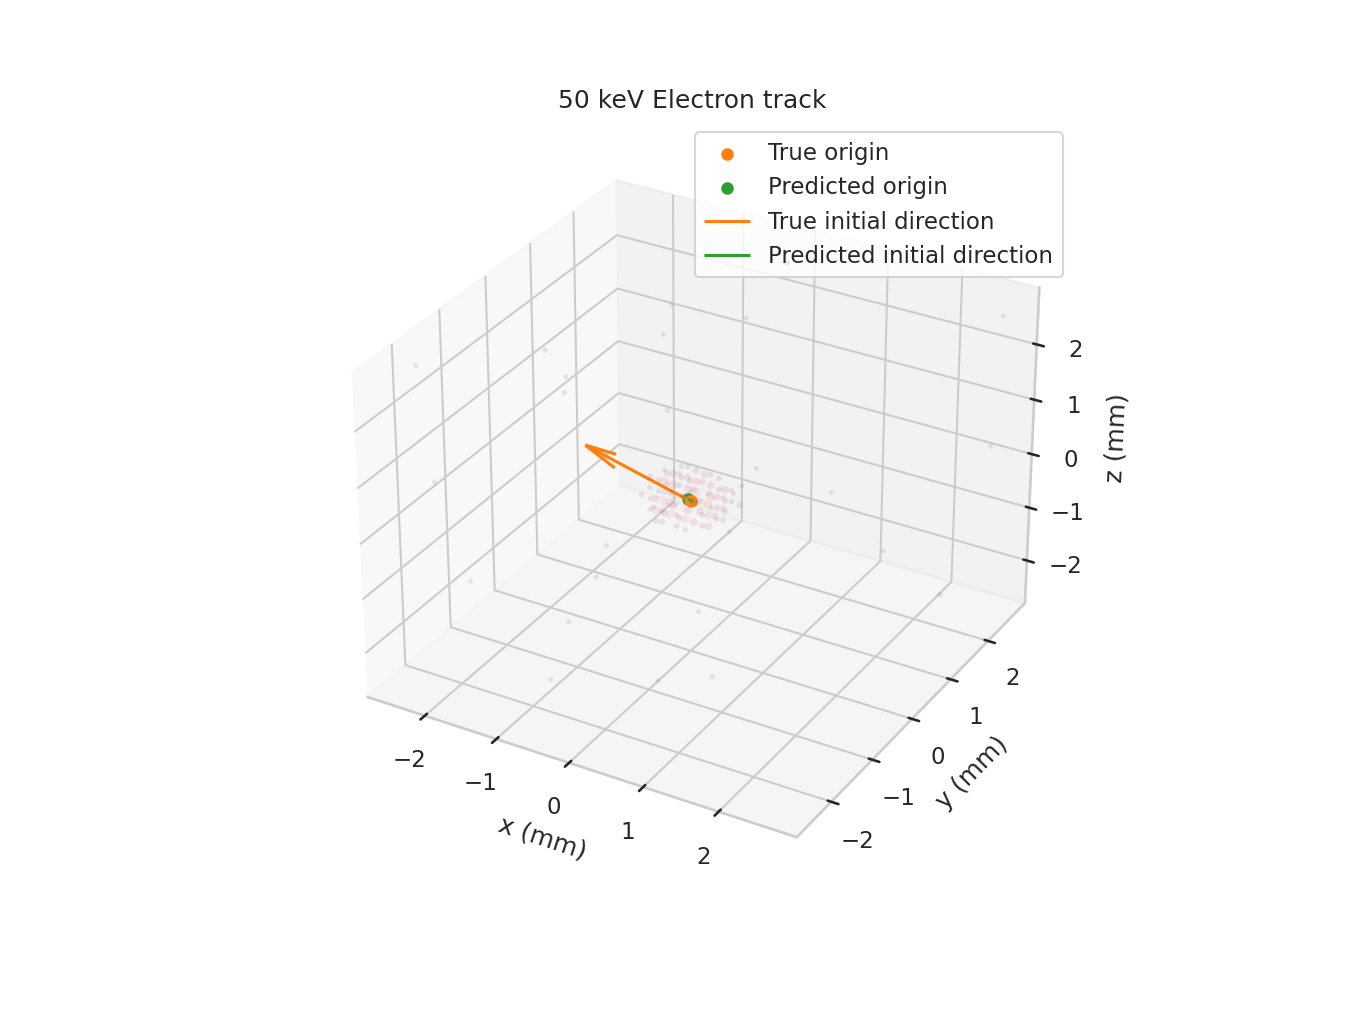

In [31]:
%matplotlib widget
sns.set_theme(style='whitegrid')
plt.ion()
plot_3D(worst_direction, x, y, z, hits, energies_test, origins=origins, predictions=predictions, ids=initial_directions, id_predictions=id_predictions/1000, figwidth=9)